# 4. Model Development

## Pre-processing

In [15]:
# Libraries imported for this notebook.

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import warnings

In [2]:
# Read Lake_Fictitious_AquaRealTime_Data_Pre_Process_Train into a dataframe, formatted dates, and indexed dates.

mean_df = pd.read_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned_Pre_Process_Train.xlsx', parse_dates=True, index_col=[0])

In [3]:
# Looked at shape

mean_df.shape

(1102, 113)

In [4]:
# Defined X and y.

X_diff_lag_all = mean_df.loc[:, mean_df.columns.str.contains('lag')] # 1st order differenced and all lag versions of metrics

y = mean_df['phycocyanin'] # Target variable

Next I created a function into which I can enter the features, target variable, type of model, and model name. The function produces RMSE scores (average of fold scores) for successive lags included in the model and graphs them. I will try multiple models and the model with the best score will be selected as my final model. I will use the graph to decide how many lags to to include in the model and then perform hypertuning.

In [12]:
# Updated function to dynamically generate lag suffixes
def fit_model(X, y, model, model_name, max_lags=20):
    # Initialize TimeSeriesSplit with number of splits equal to 5
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize lag features to include initially
    lag_features_to_include = [col for col in X.columns if col.endswith("00")]

    # Initialize lists to store RMSE values for each lag suffix
    lag_rmse = []
    
    # Iterate through each lag suffix to gradually include more features
    for lag in range(1, max_lags + 1):
        lag_suffix = str(lag).zfill(2)  # Convert to two-digit string
        lag_features_to_include += [col for col in X.columns if col.endswith(lag_suffix)]
        overall_rmse_for_suffix = []

        # Iterate through each fold
        for j, (train_index, test_index) in enumerate(tscv.split(X)):
            train_dates = X.index[train_index]
            test_dates = X.index[test_index]

            X_train, X_test = X.loc[train_dates, lag_features_to_include], X.loc[test_dates, lag_features_to_include]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model on the training data for this fold
            model.fit(X_train, y_train)

            # Make predictions on the testing data for this fold
            y_pred = model.predict(X_test)

            # Calculate RMSE for this fold
            rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred))
            overall_rmse_for_suffix.append(rmse_fold)

        # Calculate and print the overall RMSE for this lag suffix
        overall_rmse = np.mean(overall_rmse_for_suffix)
        lag_rmse.append(overall_rmse)
        print(f"RMSE for {model_name} with {lag} lags included: {overall_rmse}")

    # Plot the RMSE values for each lag suffix
    plt.plot(range(1, len(lag_rmse) + 1), lag_rmse, marker='o')
    plt.title(f"RMSE for {model_name} by number of lags included")
    plt.xlabel("Number of Lags ")
    plt.ylabel("RMSE")
    plt.xticks(range(1, len(lag_rmse) + 1), range(1, max_lags + 1))
    plt.grid(True)
    plt.show()

## Linear Regression

RMSE for Linear Regression with 1 lags included: 142.49022806323475
RMSE for Linear Regression with 2 lags included: 142.48027256337
RMSE for Linear Regression with 3 lags included: 142.73509411919608
RMSE for Linear Regression with 4 lags included: 142.48602945683558
RMSE for Linear Regression with 5 lags included: 142.0862590927993
RMSE for Linear Regression with 6 lags included: 141.69118616276177
RMSE for Linear Regression with 7 lags included: 141.73357275398982
RMSE for Linear Regression with 8 lags included: 141.86936047687632
RMSE for Linear Regression with 9 lags included: 142.08855428773796
RMSE for Linear Regression with 10 lags included: 142.66508454808218
RMSE for Linear Regression with 11 lags included: 142.96874752534063
RMSE for Linear Regression with 12 lags included: 143.49226873343113
RMSE for Linear Regression with 13 lags included: 143.96131467117436
RMSE for Linear Regression with 14 lags included: 144.44173870547098
RMSE for Linear Regression with 15 lags include

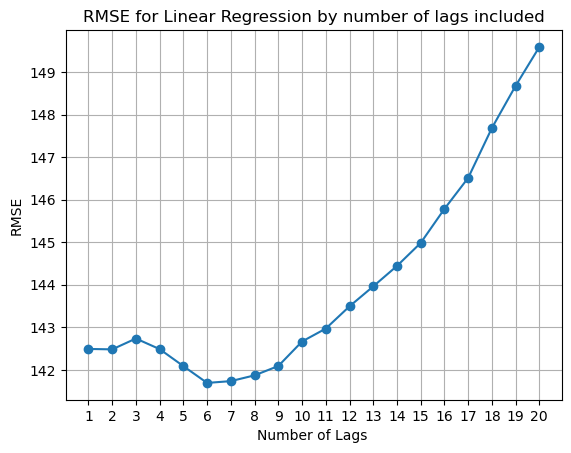

In [13]:
# Ran linear regression models using function.

fit_model(X_diff_lag_all, y, LinearRegression(), "Linear Regression")

The error gets better as I add laged features but only up to 8 lags and the scores are still not as good as the baseline model!

## Random Forest

RMSE for Random Forest with 01 lags included: 128.34575040747228
RMSE for Random Forest with 02 lags included: 125.84376409027641
RMSE for Random Forest with 03 lags included: 124.67409197399157
RMSE for Random Forest with 04 lags included: 123.79655853886621
RMSE for Random Forest with 05 lags included: 123.19828249574225
RMSE for Random Forest with 06 lags included: 123.71944122207769
RMSE for Random Forest with 07 lags included: 123.48078832484512
RMSE for Random Forest with 08 lags included: 122.26221880155109
RMSE for Random Forest with 09 lags included: 121.2551309573906
RMSE for Random Forest with 10 lags included: 121.8224229046998
RMSE for Random Forest with 11 lags included: 120.81209334929167
RMSE for Random Forest with 12 lags included: 122.17469250200773
RMSE for Random Forest with 13 lags included: 121.06606464701879
RMSE for Random Forest with 14 lags included: 121.9840152804552
RMSE for Random Forest with 15 lags included: 120.95660878346268
RMSE for Random Forest with 

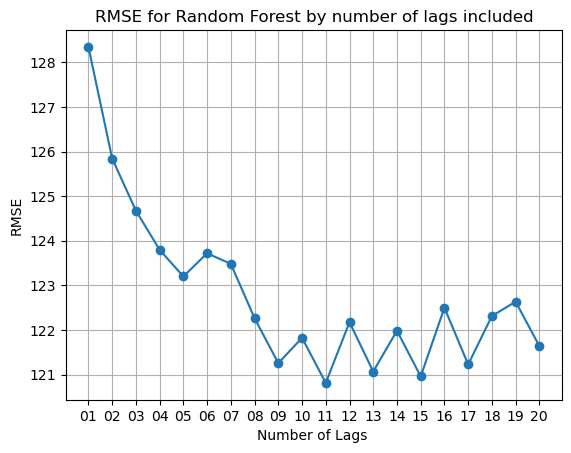

In [10]:
# Ran linear regression models using function.

fit_model(X_diff_lag_all, y, RandomForestRegressor(), "Random Forest")

The error gets better as I add laged features but only up to 11 lags and the scores are still not as good as the baseline model!

## LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 187, number of used features: 10
[LightGBM] [Info] Start training from score 20.333979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

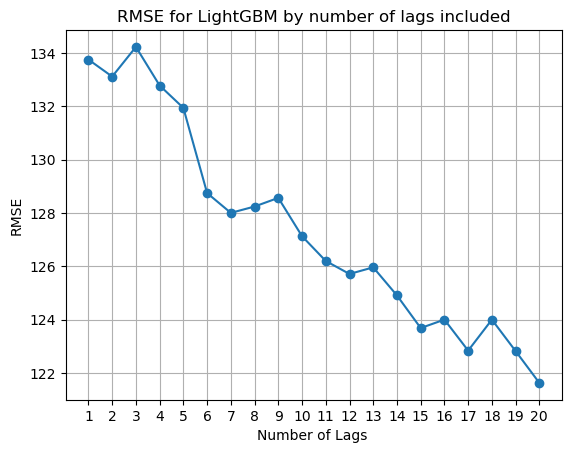

In [21]:
# Ran linear regression models using function.

fit_model(X_diff_lag_all, y, lgb.LGBMRegressor(), "LightGBM")